### Roughly patterned after LeNet-5
max instead of average pooling

The LeNet notebook contains sample code to train LeNet on MNIST. Modify the code to include biases in all the layers, and add code for training the biases. Note that all neurons in a feature map share the same bias. Run the code to show that the learning curve goes down. (This code is written for pedagogical purposes, not efficiency. It’s slow so we are not bothering with any time-consuming model selection. We will do that later with a deep learning framework.)

In [0]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import time
from IPython import display

In [0]:
# grayscale and inline plotting
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [0]:
# using scipy's 2d convolution function
conv2 = scipy.signal.convolve2d # modes include "full", "valid", and "same"

In [0]:
# visualization functions

def plot_image(image):
    nr, nc = image.shape 
    extent = [-0.5, nc-0.5, nr-0.5, -0.5] 
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')
    
def visualize(iter, errsq, errcl, x5, x4, x3, x0, w1):

    errsq = np.divide(
        np.cumsum(errsq[: iter + 1]),
        range(1, iter + 2)
    )
    
    errcl = np.divide(
        np.cumsum(errcl[: iter + 1]),
        range(1, iter + 2)
    )
    
    display.clear_output(wait=True)

    plt.subplot(4,3,1)
    plt.plot(errsq)
    plt.ylim(0,1)
    plt.title("average squared error")
    
    plt.subplot(4,3,2)
    plt.plot(errcl)
    plt.ylim(0,1)
    plt.title("average classification error")
    
    plt.subplot(4,3,3)
    plt.bar(range(len(x5)),x5)
    plt.title("class confidences")
    
    plt.subplot(4,3,4)
    plt.hist(x4)
    plt.title("x4 activations")
    
    plt.subplot(4,3,5)
    plt.hist(x3)
    plt.title("x3 activations")
    
    plt.subplot(4,3,6)
    plot_image(x0)
    plt.title("input image")
    
    for i in range(w1.shape[0]):
        plt.subplot(4,3,7+i)
        plot_image(w1[i])
        plt.title("w1 kernel channel " + str(i))

    plt.subplots_adjust(wspace=0.5)
    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

In [0]:
def maxpool(images):
    # 2x2 max pooling for set of images
    # returns MAXIMA, WINNERS
    # MAXIMA 2x smaller image, maximum of each 2x2 patch
    # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

    [k, m, n] = images.shape  # mxn images, k of them
    # reshape to k x 2 x m/2 x 2 x n/2
    im_re = np.reshape(images, (k, m/2, 2, n/2, 2))
    maxima = np.amax(np.amax(im_re, 4), 2)
    
    # obtain "flat" indices for each element
    inds = np.reshape(np.array(range(im_re.size)), im_re.shape)
    
    # run two-step argmax to determine winning indices
    curr_inds = np.argmax(im_re, 4)
    dim0, dim1, dim2, dim3 = np.indices(curr_inds.shape)
    inds = inds[dim0, dim1, dim2, dim3, curr_inds]
    im_re = np.amax(im_re, 4)
    curr_inds = np.argmax(im_re, 2)
    dim0, dim1, dim3 = np.indices(curr_inds.shape)
    winners = inds[dim0, dim1, curr_inds, dim3]
    return maxima, winners

def maxpoolback(delta_out, winners):
    # backprop through 2x2 max pooling
    #
    # DELTA_IN image, deltas
    # DELTA_OUT 2x smaller image, deltas
    # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

    [k, m, n] = delta_out.shape;  # mxn images, k of them
    delta_in = np.zeros((k,2*m,2*n))

    delta_in.flat[winners] = delta_out
    return delta_in

In [6]:
# download MNIST data or load it if previously downloaded
mnist = fetch_mldata('MNIST original', data_home="data")

# check shape - mnist.data contains train and test
print "Data shape is: ", mnist.data.shape
print "Target shape is: ", mnist.target.shape

Data shape is:  (70000, 784)
Target shape is:  (70000,)


In [0]:
# The dataset is ordered (starting with examples labeled '0', ending with examples labeled '9'). 
# To generate train examples, use 60,000 random indices into the dataset.

shuffled_indices = np.random.permutation(np.arange(mnist.data.shape[0]))
train_indices = shuffled_indices[:60000]

train = mnist.data[train_indices, :]
trainlabels = np.int_(mnist.target[train_indices])

train = np.reshape(train, (train.shape[0], 28, 28))/255.0

In [0]:
# training and architectural details

niter = train.shape[0];  # number of training examples
nepoch = 10;  # number of epochs through training set

def f(x): # hyperbolic tangent activation function
    return np.tanh(x)
def df(y): # derivative of f composed with inverse of f
    return 1 - np.multiply(y, y)

epsinit = 0.1;   # scale of weight initialization
eta = 0.01;  # learning rate parameter

# initialize two convolution layers 
n1 = 6; n2 = 16;   # numbers of feature maps
w1 = epsinit*np.random.randn(n1,5,5)  # n1 kernels
w2 = epsinit*np.random.randn(n2,n1,5,5)  # n2 x n1 kernels

x0 = np.zeros((32, 32))     # input image
x1 = np.zeros((n1, 28, 28))   # valid convolution by w1 reduces image size by 4
x1p = np.zeros((n1, 14, 14))  # pooling reduces image size by 2x
x2 = np.zeros((n2, 10, 10))   # convolution by w2 reduces image size by 4
x2p = np.zeros((n2, 5, 5))    # pooling reduces image size by 2x

# initialize three fully connected layers
n3 = 120; n4 = 84; n5 = 10              # number of neurons per layer
W3 = epsinit*np.random.randn(n3,x2p.size)   # 2D organization of x2p is discarded
W4 = epsinit*np.random.randn(n4,n3)
W5 = epsinit*np.random.randn(n5,n4)

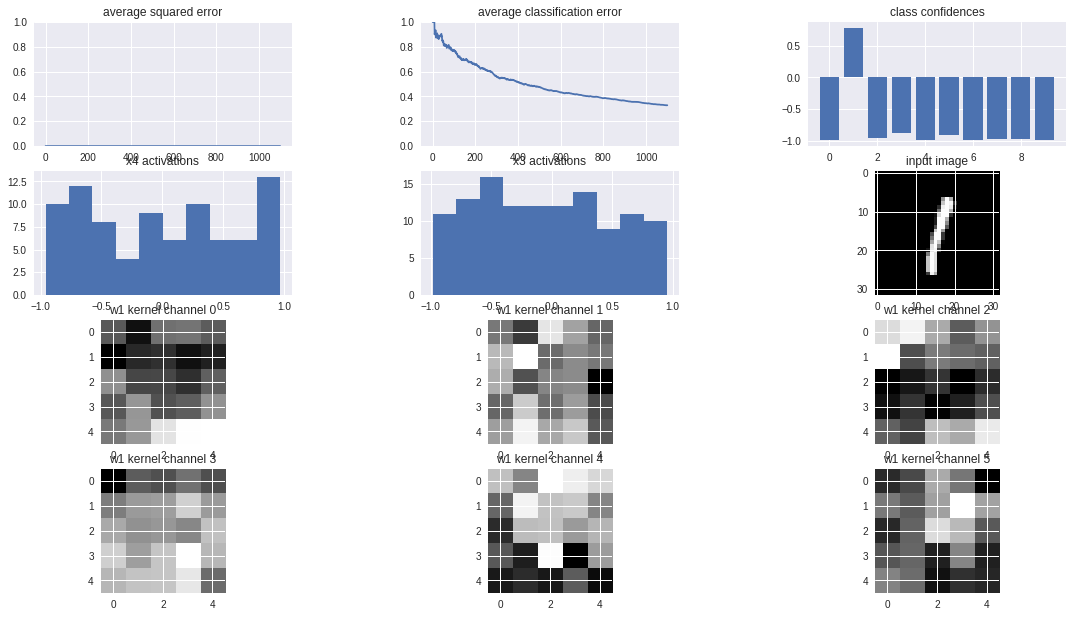

3.28279805183 seconds per 100 iterations


KeyboardInterrupt: ignored

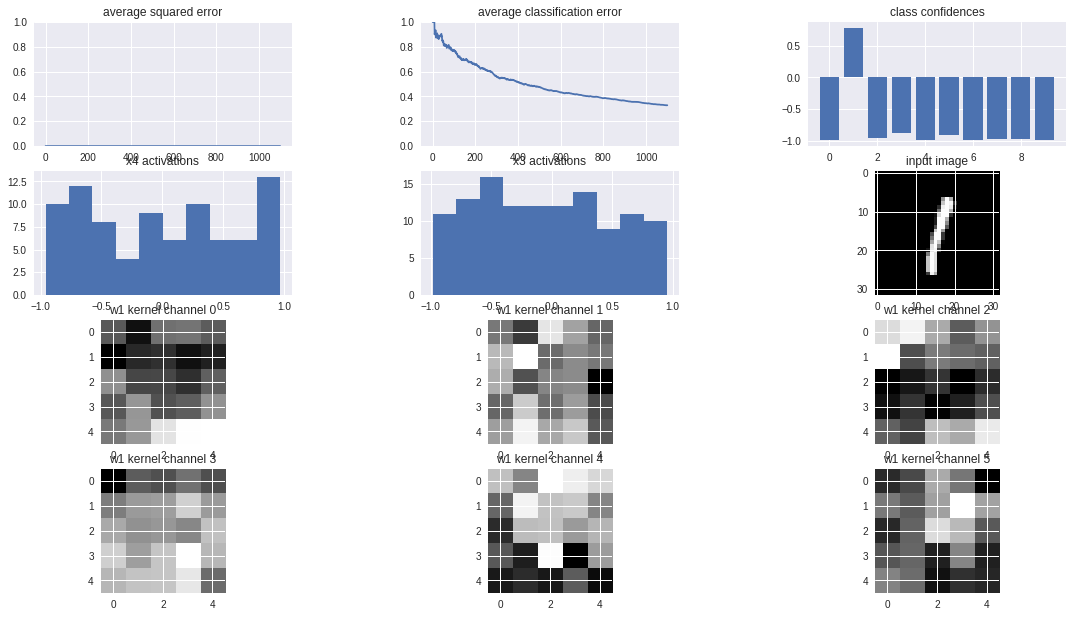

In [9]:
# training

tic = time.time()
disp_freq = 100
for iepoch in range(nepoch):
    errsq = np.zeros(niter)  # never computed
    errcl = np.zeros(niter)
    for iter in xrange(niter):
        # zero pad 28x28 image to make it 32x32
        x0 = np.zeros((32,32))
        x0[np.ix_(range(2,30),range(2,30))] = train[iter]

        for i in range(n1):
            x1[i,:,:] = conv2(x0, w1[i,:,:], "valid")
        x1 = f(x1)
        x1p, x1w = maxpool(x1)

        x2 = np.zeros(x2.shape)  # initialize to zero for accumulation
        for i in range(n2):
            for j in range(n1):
                x2[i,:,:] += conv2(x1p[j,:,:], w2[i,j,:,:], "valid")
        x2 = f(x2)
        x2p, x2w = maxpool(x2)

        # discard 2D organization of x2p by reshaping to x2p(:)
        x3 = f(np.dot(W3,np.reshape(x2p,-1)))
        x4 = f(np.dot(W4,x3))
        x5 = f(np.dot(W5,x4))
        prediction = np.argmax(x5);
        errcl[iter] = prediction != trainlabels[iter];
        
        # backward pass
        d = -1*np.ones(n5)
        d[trainlabels[iter]] = 1;  # target output vector
        err = d - x5; 
        delta5 = np.multiply(err,df(x5));
        delta4 = np.multiply(np.dot(W5.T,delta5),df(x4))
        delta3 = np.multiply(np.dot(W4.T,delta4),df(x3))
        delta2p = np.dot(W3.T,delta3)
        delta2p = np.reshape(delta2p, x2p.shape)  # restore 2D organization
        delta2 = np.multiply(maxpoolback(delta2p, x2w),df(x2))
        delta1p = np.zeros(x1p.shape)
        for j in range(n1):
            for i in range(n2):
                delta1p[j,:,:] += conv2(delta2[i,:,:], w2[i,j][np.ix_(range(w2.shape[2]-1,-1,-1),range(w2.shape[3]-1,-1,-1))], "full")
        delta1 = np.multiply(maxpoolback(delta1p, x1w),df(x1))

        # weight updates
        W5 += eta*np.dot(np.atleast_2d(delta5).T,np.atleast_2d(x4))
        W4 += eta*np.dot(np.atleast_2d(delta4).T,np.atleast_2d(x3))
        W3 += eta*np.dot(np.atleast_2d(delta3).T,np.reshape(x2p,(1,x2p.size)))
        for i in range(n2):
            for j in range(n1):
                w2[i,j,:,:] += eta*conv2(x1p[j][np.ix_(range(x1p.shape[1]-1,-1,-1),range(x1p.shape[2]-1,-1,-1))], delta2[i,:,:], "valid")
        for i in range(n1):
            w1[i,:,:] += eta*conv2(x0[np.ix_(range(x0.shape[0]-1,-1,-1),range(x0.shape[1]-1,-1,-1))], delta1[i,:,:], "valid")
        if (iter+1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(iter, errsq, errcl, x5, x4, x3, x0, w1)
            print str(time.time() - tic) + " seconds per " + str(disp_freq) + " iterations"
            tic = time.time()
            time.sleep(0.01)

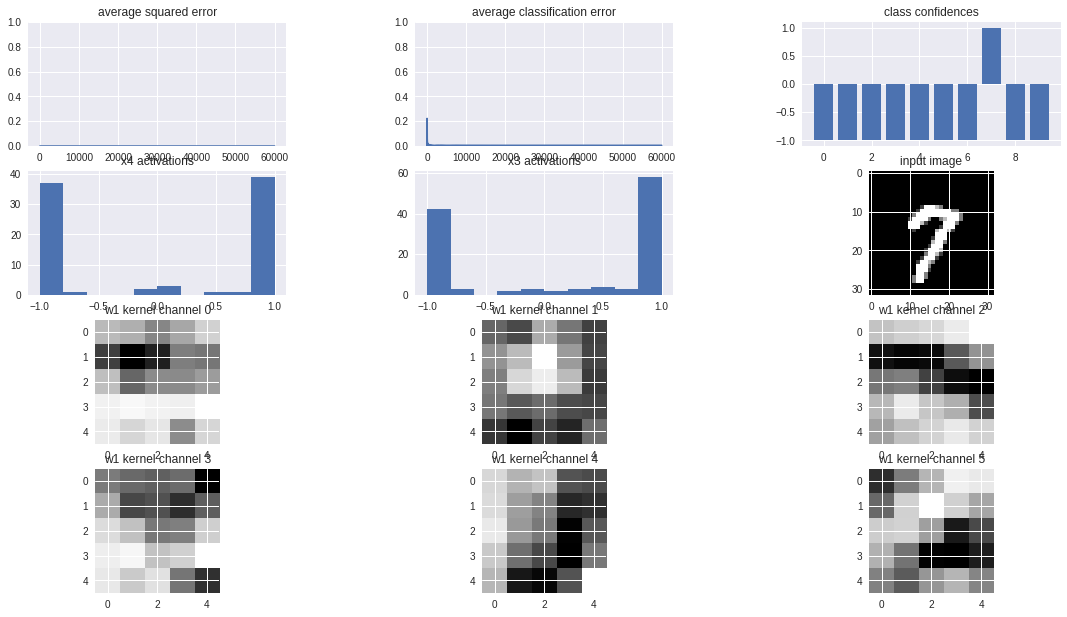

4.26686096191 seconds per 100 iterations


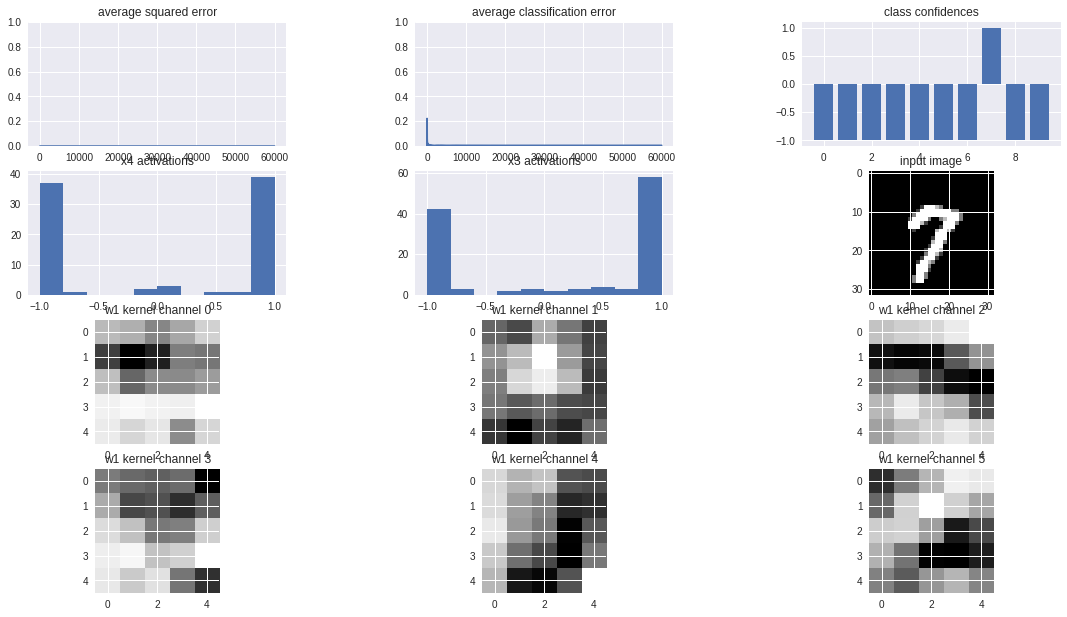

In [9]:
# training and architectural details
# Bias added 

niter = train.shape[0];  # number of training examples
nepoch = 10;  # number of epochs through training set

def f(x): # hyperbolic tangent activation function
    return np.tanh(x)
def df(y): # derivative of f composed with inverse of f
    return 1 - np.multiply(y, y)

epsinit = 0.1;   # scale of weight initialization
eta = 0.01;  # learning rate parameter

# initialize two convolution layers 
n1 = 6; n2 = 16;   # numbers of feature maps
w1 = epsinit*np.random.randn(n1,5,5)  # n1 kernels
w2 = epsinit*np.random.randn(n2,n1,5,5)  # n2 x n1 kernels
b1 = epsinit*np.random.randn(n1) # Bias initialization
b2 = epsinit*np.random.randn(n2) # Bias initialization

x0 = np.zeros((32, 32))     # input image
x1 = np.zeros((n1, 28, 28))   # valid convolution by w1 reduces image size by 4
x1p = np.zeros((n1, 14, 14))  # pooling reduces image size by 2x
x2 = np.zeros((n2, 10, 10))   # convolution by w2 reduces image size by 4
x2p = np.zeros((n2, 5, 5))    # pooling reduces image size by 2x

# initialize three fully connected layers
n3 = 120; n4 = 84; n5 = 10              # number of neurons per layer
W3 = epsinit*np.random.randn(n3,x2p.size)   # 2D organization of x2p is discarded
W4 = epsinit*np.random.randn(n4,n3)
W5 = epsinit*np.random.randn(n5,n4)
b3 = epsinit*np.random.randn(n3) # Bias initialization
b4 = epsinit*np.random.randn(n4) # Bias initialization
b5 = epsinit*np.random.randn(n5) # Bias initialization

# training

tic = time.time()
disp_freq = 100
for iepoch in range(nepoch):
    errsq = np.zeros(niter)  # never computed
    errcl = np.zeros(niter)
    for iter in xrange(niter):
        # zero pad 28x28 image to make it 32x32
        x0 = np.zeros((32,32))
        x0[np.ix_(range(2,30),range(2,30))] = train[iter]

        for i in range(n1):
            x1[i,:,:] = conv2(x0, w1[i,:,:], "valid") + b1[i]
        x1 = f(x1)
        x1p, x1w = maxpool(x1)

        x2 = np.zeros(x2.shape)  # initialize to zero for accumulation
        for i in range(n2):
            for j in range(n1):
                x2[i,:,:] += conv2(x1p[j,:,:], w2[i,j,:,:], "valid") + b2[i]
        x2 = f(x2)
        x2p, x2w = maxpool(x2)

        # discard 2D organization of x2p by reshaping to x2p(:)
        x3 = f(np.dot(W3,np.reshape(x2p,-1)) + b3)
        x4 = f(np.dot(W4,x3) + b4)
        x5 = f(np.dot(W5,x4) + b5)
        prediction = np.argmax(x5);
        errcl[iter] = prediction != trainlabels[iter];
        
        # backward pass
        d = -1*np.ones(n5)
        d[trainlabels[iter]] = 1;  # target output vector
        err = d - x5; 
        delta5 = np.multiply(err,df(x5));
        delta4 = np.multiply(np.dot(W5.T,delta5),df(x4))
        delta3 = np.multiply(np.dot(W4.T,delta4),df(x3))
        delta2p = np.dot(W3.T,delta3)
        delta2p = np.reshape(delta2p, x2p.shape)  # restore 2D organization
        delta2 = np.multiply(maxpoolback(delta2p, x2w),df(x2))
        delta1p = np.zeros(x1p.shape)
        #print 'delta2', len(delta2[0])
        for j in range(n1):
            for i in range(n2):
                delta1p[j,:,:] += conv2(delta2[i,:,:], w2[i,j][np.ix_(range(w2.shape[2]-1,-1,-1),range(w2.shape[3]-1,-1,-1))], "full")
        delta1 = np.multiply(maxpoolback(delta1p, x1w),df(x1))
        
        # weight updates
        W5 += eta*np.dot(np.atleast_2d(delta5).T,np.atleast_2d(x4))
        W4 += eta*np.dot(np.atleast_2d(delta4).T,np.atleast_2d(x3))
        W3 += eta*np.dot(np.atleast_2d(delta3).T,np.reshape(x2p,(1,x2p.size)))
        
        b5 += eta * delta5  # Bias updating
        b4 += eta * delta4  # Bias updating
        b3 += eta * delta3  # Bias updating
        for i in range(n2):
            for j in range(n1):
                w2[i,j,:,:] += eta*conv2(x1p[j][np.ix_(range(x1p.shape[1]-1,-1,-1),range(x1p.shape[2]-1,-1,-1))], delta2[i,:,:], "valid")
            b2[i] +=eta * np.sum(delta2[i]) # Bias updating
        for i in range(n1):
            w1[i,:,:] += eta*conv2(x0[np.ix_(range(x0.shape[0]-1,-1,-1),range(x0.shape[1]-1,-1,-1))], delta1[i,:,:], "valid")
            b1[i] += eta * np.sum(delta1[i]) # Bias updating
        if (iter+1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(iter, errsq, errcl, x5, x4, x3, x0, w1)
            print str(time.time() - tic) + " seconds per " + str(disp_freq) + " iterations"
            tic = time.time()
            time.sleep(0.01)